In [70]:
import json 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_df = pd.read_json("polyrating.json",orient='columns')

def flatten(a):
    try:
        return a[0]
    except:
        return a
    
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [ ]:
raw_df1 = explode(raw_df,"reviews")
split_review = raw_df1["reviews"].apply(pd.Series)
df = raw_df1.join(split_review)

In [64]:
df = df.drop("reviews",axis=1)

## Cleaning

### Make rating numeric

In [4]:
df["agg_rating"] = pd.to_numeric(df["agg_rating"].str[:4], errors="coerce")

In [5]:
def get_course_num(course):
    if len(course) == 2:
        return course[1]
    else:
        return course

df["year"] = df["date"].str.extract('(\d+)')
df["month"] = df["date"].str[:3]
df["course_num"] = pd.to_numeric(df["class"].str.split("_").apply(get_course_num))
df["level"] = pd.to_numeric(df['course_num'].astype(str).str[0] + "00")

df = df[(df["course_num"] > 99) & (df["course_num"] < 551)]

## Average Grade by Year

In [6]:
df["gpa"] = df.grade.map({
    "A":4,
    "B":3,
    "C":2,
    "D":1,
    "F":0
})

In [7]:
df.groupby("standing")["gpa"].mean()[["Freshman", "Sophomore", "Junior", "Senior"]].plot.bar(ylim=(3.05, 3.25))

## Average Rating of Professor by Year

In [69]:
df.groupby("standing")["agg_rating"].mean()[["Freshman", "Sophomore", "Junior", "Senior"]].plot.bar(ylim=(2.4, 2.75), title="Average Grade Earned by Grade Level")

DataError: No numeric types to aggregate

## Polyrating vs. Average Grade

In [9]:
profs = df["prof_name"].value_counts()[df["prof_name"].value_counts() > 30].to_frame().index.tolist()
high_rating_count = df[(df["prof_name"].isin(profs))]

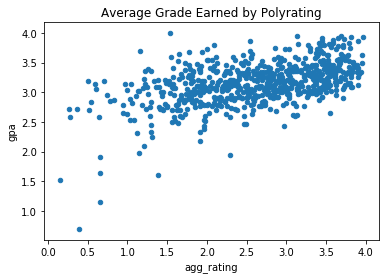

In [26]:
professor_means = high_rating_count.groupby("prof_name")[["agg_rating","gpa"]].mean()
high_rating_count.groupby("prof_name")[["agg_rating","gpa"]].mean().plot.scatter(x="agg_rating", y="gpa", title="Average Grade Earned by Polyrating")

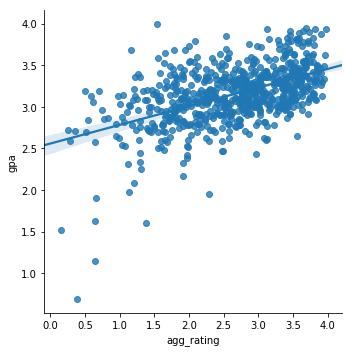

In [30]:
import seaborn as sns
import math

avg_rev_len = high_rating_count.groupby("prof_name")["review"].apply(lambda x: np.mean(x.str.len()))
professor_means["avg_rev_len"] = avg_rev_len
sns.lmplot(x="agg_rating", y="gpa", data=professor_means, fit_reg=True)
professor_means["log_transform"] = np.log(professor_means["avg_rev_len"])

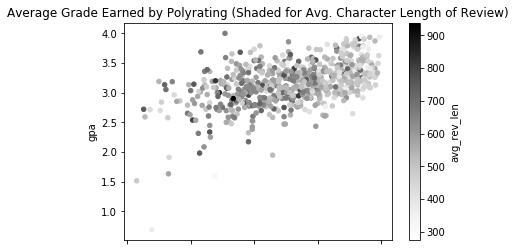

In [32]:
professor_means[professor_means["avg_rev_len"] < 1000].plot.scatter(x="agg_rating", y="gpa", c="avg_rev_len", title="Average Grade Earned by Polyrating (Shaded for Avg. Character Length of Review)")

## Avg. Grade by Course Type

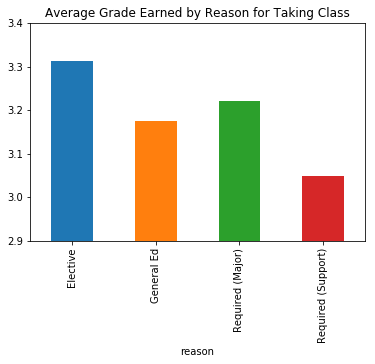

In [33]:
df.groupby("reason")["gpa"].mean().drop("N/A").plot.bar(ylim=(2.9, 3.4), title="Average Grade Earned by Reason for Taking Class")

## Avg. Grade by Year and Month

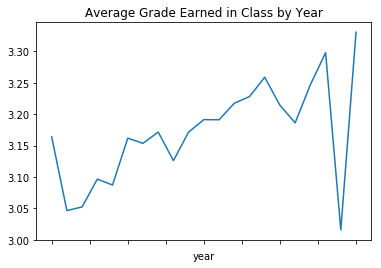

In [34]:
df.groupby("year")["gpa"].mean().plot(title="Average Grade Earned in Class by Year")

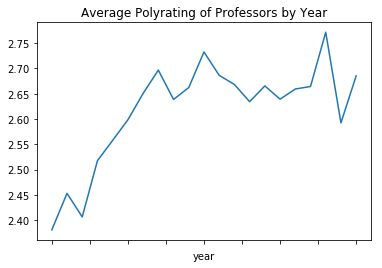

In [35]:
df.groupby("year")["agg_rating"].mean().plot(title="Average Polyrating of Professors by Year")

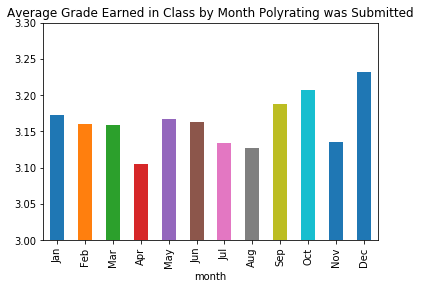

In [36]:
df.groupby("month")["gpa"].mean()[["Jan", "Feb", "Mar", "Apr","May", "Jun",
                                   "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]].plot.bar(ylim=(3, 3.3), title="Average Grade Earned in Class by Month Polyrating was Submitted")

## Average Grade by Course Level

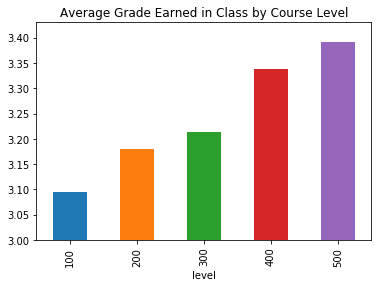

In [38]:
df.groupby("level")["gpa"].mean().plot.bar(ylim=(3, 3.43), title="Average Grade Earned in Class by Course Level")

## Polyrating by Keywords

In [18]:
df["awesome"] = df["review"].str.contains("awesome")
df["shit"] = df["review"].str.contains("shit")

awesome
False    2.602295
True     3.090410
Name: agg_rating, dtype: float64

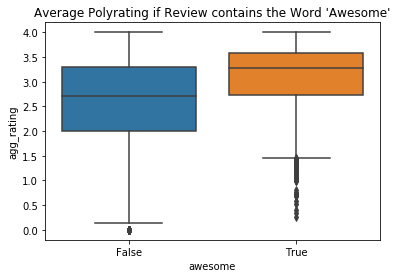

In [40]:
import seaborn as sns

sns.boxplot(x="awesome", y="agg_rating", data=df).set_title("Average Polyrating if Review contains the Word 'Awesome'")
df.groupby("awesome")["agg_rating"].mean()

shit
False    2.635707
True     2.358353
Name: agg_rating, dtype: float64

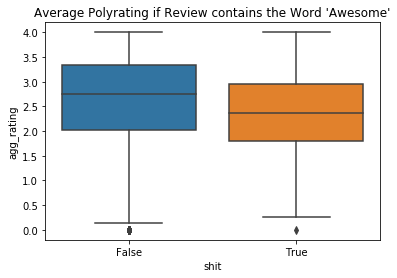

In [44]:
sns.boxplot(x="shit", y="agg_rating", data=df).set_title("Average Polyrating if Review contains the Word 'Awesome'")
df.groupby("shit")["agg_rating"].mean()

In [21]:
def gender_finder(review):
    m_total = 0
    m_total += review.lower().split().count("he")
    m_total += review.lower().split().count("his")    
    m_total += review.lower().split().count("him")    
    f_total = 0
    f_total += review.lower().split().count("she")    
    f_total += review.lower().split().count("her")    
    return m_total - f_total
    
df["gender"] = df["review"].apply(gender_finder)

In [22]:
profs_gend = df.groupby('prof_name')["gender"].sum().to_frame()

def determine_gend(num):
    if num > 0:
        return "male"
    elif num < 0:
        return "female"
    else:
        return "none"

In [23]:
def gender_getter(name, dict):
    return dict[name]

profs_gend["gend"] = profs_gend["gender"].apply(determine_gend)
profs_gend_dict = profs_gend.drop("gender", axis=1).to_dict()
df["genderr"] = df["prof_name"].apply(gender_getter(profs_gend_dict))

TypeError: gender_getter() missing 1 required positional argument: 'dict'

In [49]:
import csv
with open("reviews.csv", 'wb') as myfile:
    wr=csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(df["review"].tolist())

TypeError: a bytes-like object is required, not 'str'

In [ ]:
profs_gend_dict['Abel, Christina']

['really interesting',
 "anytext or 1=1'",
 'I had Dr. Abel a year ago as a freshman, but PolyRatings did not have her listed yet. I\'m happy they updated their professor list so I could share how legit she is at teaching chem. To start off, Chem 124 is the "weeder" class for incoming freshmen, and I was absolutely terrible at chem in high school. Therefore, I was dreading taking a college level chem course. As a great suprise, Dr. Abel changed my attitude towards chem for the better with her concise lectures and friendly personality. I understood chem much better with her as a teacher, and she goes out of the way to make sure you understand the course material. She provides many supplemental handouts for practice, plenty of office hours, and even gives an extra assignment towards the end of the quarter to help your grade out (I don\'t know any other chem professor that does this). In addition, she\'s a very fair grader and curves the final grades nicely. Suffice it to say, Chem 124/12

In [58]:
alt.Chart(df.groupby("standing")["agg_rating"].mean()[["Freshman", "Sophomore", "Junior", "Senior"]]).mark_bar().encode(
    x='a',
    y='b'
)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/altair/vegalite/v2/api.py:97: UserWarning: data of type <class 'pandas.core.series.Series'> not recognized
  warnings.warn("data of type {} not recognized".format(type(data)))


ValueError: a encoding field is specified without a type; the type cannot be automatically inferred because the data is not specified as a pandas.DataFrame.

Chart({
  data: standing
  Freshman     2.694664
  Sophomore    2.618995
  Junior       2.574646
  Senior       2.574173
  Name: agg_rating, dtype: float64,
  encoding: EncodingWithFacet({
    x: X({
      shorthand: 'a'
    }),
    y: Y({
      shorthand: 'b'
    })
  }),
  mark: 'bar'
})

In [56]:
!pip install altair

You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


  Could not find a version that satisfies the requirement pyplot (from versions: )
No matching distribution found for pyplot
You are using pip version 18.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
